In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.auto import tqdm
import shutil

import torch
import torchvision

from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets, utils

from sklearn.model_selection import train_test_split
import json

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np
import sklearn.metrics as met

### Dataset Loading

In [2]:
path = '/Users/zvele/Desktop/Visión Artificial/Proyecto_Final/Splited_dataset'
train = os.listdir(path+'/train')
test = os.listdir(path+'/test')

data_train = []
train_labels = []
for i in range(len(train)):
    aux = os.listdir(path+'/train/'+train[i])
    data_train.append(aux)
    train_labels.append(train[i])
    
data_test = []
test_labels = []
for i in range(len(test)):
    aux = os.listdir(path+'/test/'+test[i])
    data_test.append(aux)
    test_labels.append(train[i])

### Dataset Conditioning

In [3]:
# Define the transforms to be performed over every subset instance
train_transforms = transforms.Compose([
                                      #  transforms.RandomCrop(64, padding=4, padding_mode='reflect'), 
                                      #  transforms.RandomHorizontalFlip(),
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                      #  transforms.Grayscale(num_output_channels=1), 
                                      #  transforms.Normalize(*stats,inplace=True)
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      # transforms.Grayscale(num_output_channels=1), 
                                      #  transforms.Normalize(*stats,inplace=True)
                                      ])

# Map the training and testing subsets 
train_data = datasets.ImageFolder(path+'/train',       
                    transform=train_transforms)

test_data = datasets.ImageFolder(path+'/test',
                    transform=test_transforms)

batch_size = 8

# Using function torch.utils.data.random_split to divide train_data subset into 
# two: train dataset (80%) and validation dataset (20%)
train_data_l = len(train_data) # train_data length
p20 = int(train_data_l*0.3) # 30 percent

val_data, train_data =  torch.utils.data.random_split(train_data, (p20, train_data_l-p20))

# PyTorch data loaders
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size*2, shuffle=True, num_workers=0)

### Showing a Sample from the Dataset 

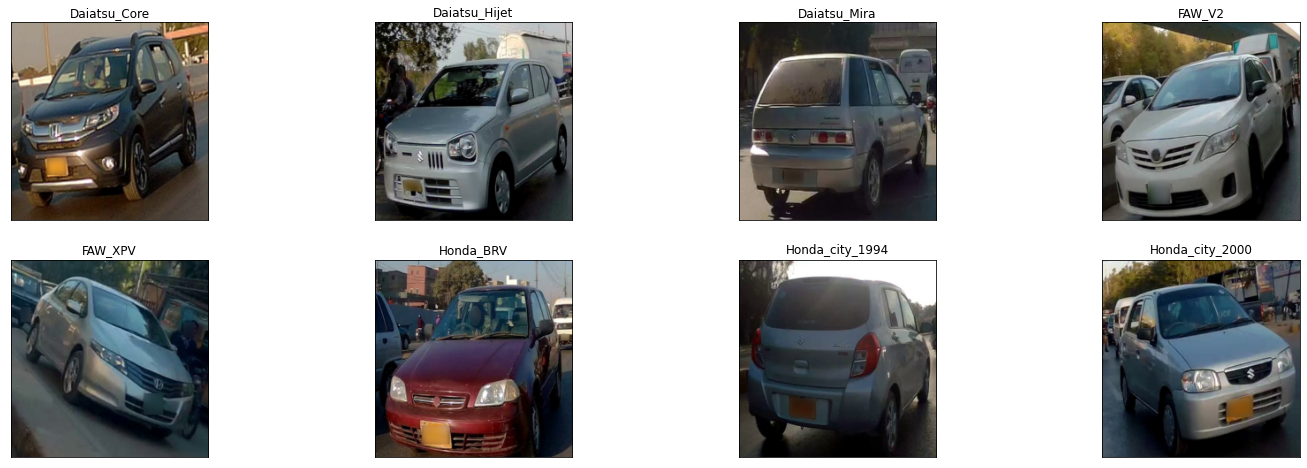

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
    
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.permute(0,2,3,1).numpy()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(train_labels[idx])

### Importing AlexNet pretrained model

In [5]:
from torchvision import models

# Load the pretrained model Alexnet
pretrained_model = models.alexnet(pretrained=True)
print(pretrained_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Turning the first 8 layers off

In [19]:
# Freeze all layers to implement transfer learning
#for idx, param in enumerate(pretrained_model.features.parameters()):
#  if idx < 10:  # 10 original
#  param.required_grad = False

num_features_last_layer = pretrained_model.classifier[6].in_features
print("Num. of input nodes for the last fully-connected layer: ",num_features_last_layer)
classifier = list(pretrained_model.classifier.children())[:-1] 
print("Original classifier architecture:",classifier)

classifier.extend([nn.Linear(num_features_last_layer, len(train_labels))])
pretrained_model.classifier = nn.Sequential(*classifier) 
print("New classifier architecture",classifier)

for param in pretrained_model.classifier.parameters():
  param.requires_grad = True

Num. of input nodes for the last fully-connected layer:  4096
Original classifier architecture: [Dropout(p=0.5, inplace=False), Linear(in_features=9216, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True)]
New classifier architecture [Dropout(p=0.5, inplace=False), Linear(in_features=9216, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Linear(in_features=4096, out_features=48, bias=True)]


### Retraining the model for the chosen dataset

In [20]:
# define a loss function
criterion = nn.CrossEntropyLoss()
# stochastic gradient descent with a small learning rate AND some momentum
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

In [21]:
# This time, we will use the GPU to train the model. So, don't forget to change 
# the runtime before running this cell. This might require to run the previous cells again.  
device = "cuda" if torch.cuda.is_available() else "cpu"
pretrained_model.to(device)

# Define a function which takes in a number of epochs to train for. 
# this function return the total loss over time, which you can visualize if needed
def train(model, n_epochs):
    
    # to track the loss as the network trains
    loss_over_time = [] 
    
    # loop over the dataset multiple times
    for epoch in tqdm(range(n_epochs),total=n_epochs):  
        
        running_loss = 0.0
        avg_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):

            # get the input images and their corresponding labels
            inputs, labels = data
            # move inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                
                print("Epoch: ",epoch + 1," Batch:",batch_i+1, "Avg. Loss: ",avg_loss  )
                running_loss = 0.0
            
        loss_over_time.append(avg_loss)

    print('Finished Training')
    return loss_over_time

# define the number of epochs to train for
n_epochs = 10 

# call train
training_loss = train(pretrained_model, n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Finished Training


In [10]:

# define the number of epochs to train for
n_epochs = 100

# call train
training_loss1 = train(pretrained_model, n_epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

Finished Training


In [11]:

# define the number of epochs to train for
n_epochs = 150

# call train
training_loss2 = train(pretrained_model, n_epochs)

  0%|          | 0/150 [00:00<?, ?it/s]

Finished Training


### Training Loss Graph

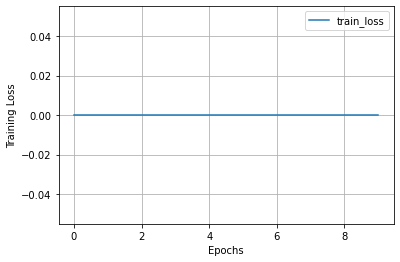

In [23]:
# Show a chart with the training loss
hist = {'train_loss':training_loss,}

df = pd.DataFrame(hist)
ax = df.plot(grid=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Training Loss")
plt.show()

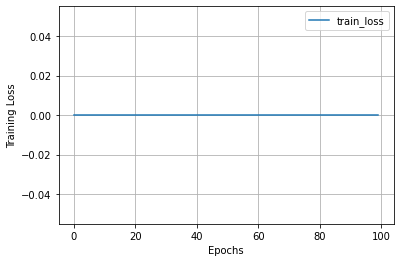

In [13]:
# Show a chart with the training loss
hist = {'train_loss':training_loss1,}

df = pd.DataFrame(hist)
ax = df.plot(grid=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Training Loss")
plt.show()

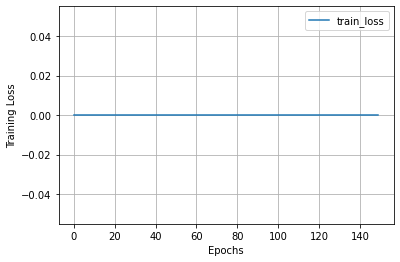

In [14]:
# Show a chart with the training loss
hist = {'train_loss':training_loss2,}

df = pd.DataFrame(hist)
ax = df.plot(grid=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Training Loss")
plt.show()

### Evaluating the Model


In [10]:
# Let's define a test function to evaluate the model
def test(model):
  # initialize tensor and lists to monitor test loss and accuracy
  test_loss = torch.zeros(1)
  class_correct = list(0. for i in range(64))
  class_total = list(0. for i in range(64))

  test_loss = test_loss.to(device)

  # set the module to evaluation mode
  model.eval()

  for batch_i, data in tqdm(enumerate(test_loader),total=len(test_loader)):
      
      # get the input images and their corresponding labels
      inputs, labels = data

      # move inputs and labels to GPU
      inputs, labels = inputs.to(device), labels.to(device)
      
      # forward pass to get outputs
      outputs = model(inputs)

      # calculate the loss
      loss = criterion(outputs, labels)
              
      # update average test loss 
      test_loss = test_loss + ((torch.ones(1).to(device) / (batch_i + 1)) * (loss.data - test_loss))
      
      # get the predicted class from the maximum value in the output-list of class scores
      _, predicted = torch.max(outputs.data, 1)
      
      # compare predictions to true label
      # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
      correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
      
      # calculate test accuracy for *each* object class
      # we get the scalar value of correct items for a class, by calling `correct[i].item()`
      for i in range(len(labels)):
          label = labels.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  print('Test Loss:',test_loss.cpu().numpy()[0])

  for i in range(8):
      if class_total[i] > 0:
          print('Test Accuracy of ',train_labels[i],':', 100 * class_correct[i] / class_total[i],'%')
      else:
          print('Test Accuracy of ',train_labels[i],': No training examples')

test(pretrained_model)

  0%|          | 0/47 [00:00<?, ?it/s]

Test Loss: 0.78560317
Test Accuracy of  Daiatsu_Core : 85.0 %
Test Accuracy of  Daiatsu_Hijet : 90.0 %
Test Accuracy of  Daiatsu_Mira : 95.0 %
Test Accuracy of  FAW_V2 : 71.42857142857143 %
Test Accuracy of  FAW_XPV : 83.33333333333333 %
Test Accuracy of  Honda_BRV : 100.0 %
Test Accuracy of  Honda_city_1994 : 80.76923076923077 %
Test Accuracy of  Honda_city_2000 : 40.0 %


### Visualize a sample test result

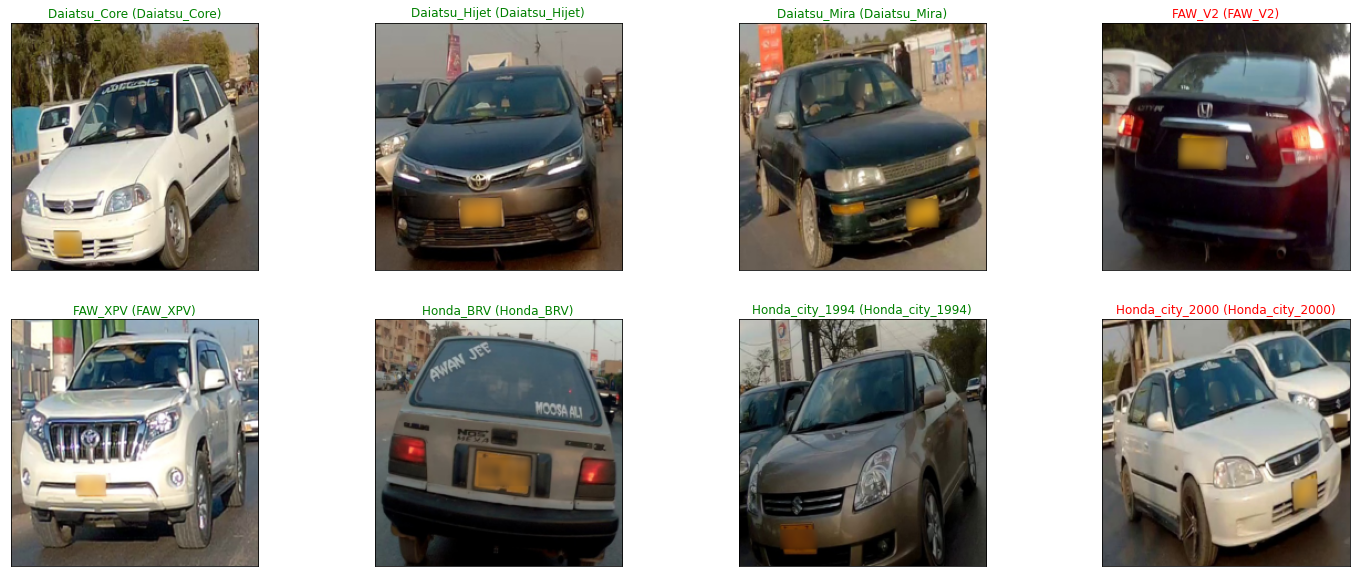

In [16]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# move inputs and labels to GPU
images, labels = images.to(device), labels.to(device)

# get predictions
preds = np.squeeze(pretrained_model(images).data.max(1, keepdim=True)[1].cpu().numpy())
images = images.permute(0,2,3,1).cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(""+str(test_labels[idx])+" ("+str(train_labels[idx])+")",color=("green" if preds[idx]==labels[idx] else "red"))

## Metrics
### Confusion Matrix

In [1]:
labels = labels.cpu()
labels.numpy()

conf_mat = met.confusion_matrix(labels, preds)

NameError: name 'labels' is not defined

In [12]:
labels = labels.cpu()
labels.numpy()
accuracy_n = met.accuracy_score(labels, preds)
accuracy = met.accuracy_score(labels, preds, normalize = False)
f1_score_w = met.f1_score(labels, preds, average = 'weighted')
conf_mat = met.confusion_matrix(labels, preds)

print("Accuracy Score: ", accuracy)
print("Accuracy Score (normalized): ", accuracy_n)
print("F1 Score (weighted): ", f1_score_w)
print("Confussion matrix:")
met.confusion_matrix(labels, preds)


Accuracy Score:  13
Accuracy Score (normalized):  0.8125
F1 Score (weighted):  0.8229166666666666
Confussion matrix:


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]], dtype=int64)